In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import sympy as sp
sp.init_printing()
import pandas as pd
import urllib.request
import math

# Actividad 05: Interpolación

---
### Profesor: Juan Marcos Marín
### Nombre: Miguel Angel Perdomo Gaitan
*Métodos computacionales 2025-I*

---

# 1
Supongamos que queremos interpolar la función  $f(x)=\sin(x)$  usando los puntos  $x_0=0$ ,  $x_1=\pi/2$ , y  $x_2=\pi$.

Encuentre el polinomio de interpolación de Lagrange y el error asociado al misma. Recuerde que el error de interpolación de Lagrange puede expresarse explícitamente como:

\begin{equation}
f(x) - P(x) = \epsilon = \frac{1}{(n+1)!} f^{(n+1)}(\xi)(x - x_0)(x - x_1) ... (x - x_n)
\end{equation}

Donde:
- $f^{(n+1)}(\xi)$ es la derivada de orden $n$ de la función $f(x)$ evaluada en algún punto $\xi$ en el intervalo de interpolación.

- Repita el numeral anterior, pero para los polinomios de interpolación de Hermite, conociendo que:


$$
f(x) - P(x) = \epsilon = \frac{f^{(2n+2)}(\xi)}{(2n+2)!} \prod_{i=0}^{n} (x - x_i)^2
$$

*Nota: recuerde que los indices en python inician en 0, luego si tenemos $n+1$ datos el polinomio es de orden $n$*

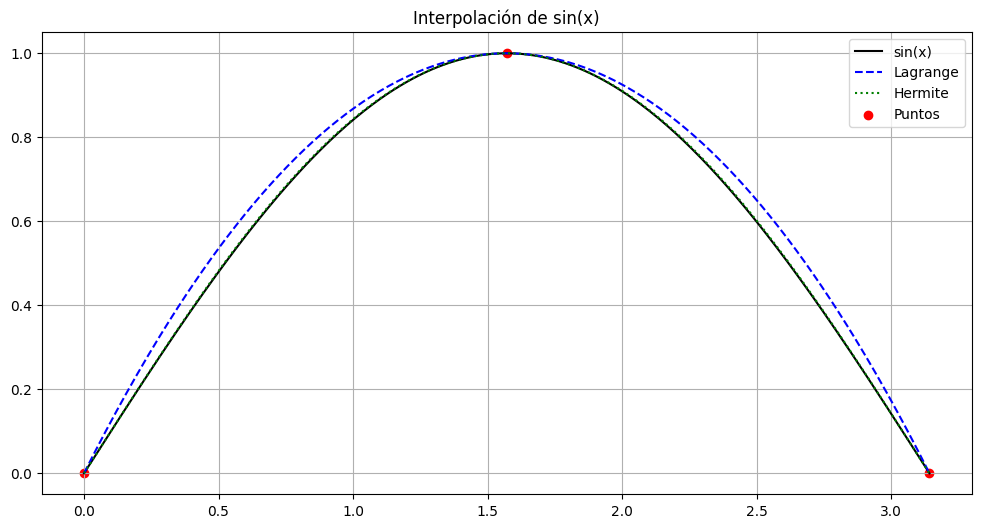

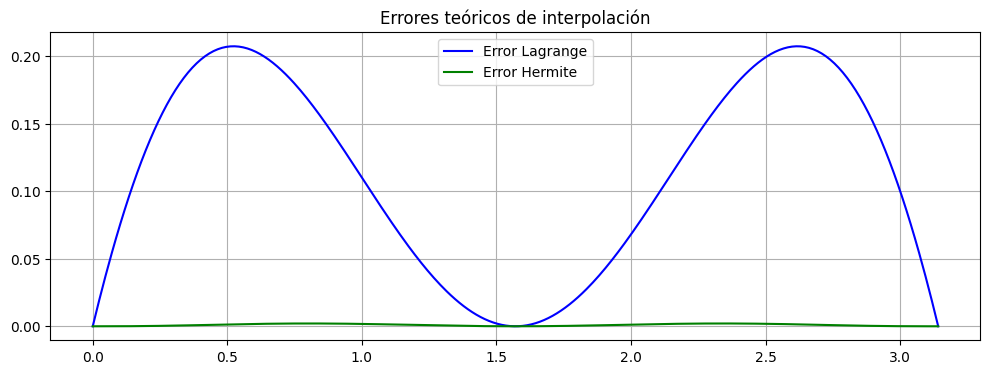

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import sympy as sp
import pandas as pd
import urllib.request
import math

# Inicialización simbólica
sp.init_printing()
x = sp.Symbol('x')
f = sp.sin(x)

# Puntos dados
x_vals = np.array([0, np.pi/2, np.pi])
y_vals = np.sin(x_vals)
dy_vals = np.cos(x_vals)  # derivadas de sin(x) para Hermite

# -----------------------------
# 1. POLINOMIO DE LAGRANGE
# -----------------------------
poly_lagrange = lagrange(x_vals, y_vals)
f_lagrange = lambda x_num: poly_lagrange(x_num)

# Error teórico de Lagrange
def lagrange_error(x_eval):
    n = len(x_vals) - 1
    f_deriv = sp.diff(f, x, n+1)
    f_deriv_func = sp.lambdify(x, f_deriv, 'numpy')
    product = np.prod([x_eval - xi for xi in x_vals])
    return (f_deriv_func(x_eval) / math.factorial(n+1)) * product

# -----------------------------
# 2. POLINOMIO DE HERMITE (forma manual)
# -----------------------------
def hermite_interpol(x_vals, y_vals, dy_vals, x_eval):
    n = len(x_vals)
    z = np.repeat(x_vals, 2)
    Q = np.zeros((2*n, 2*n))
    Q[:,0] = np.repeat(y_vals, 2)

    for i in range(n):
        Q[2*i+1][1] = dy_vals[i]
        if i != 0:
            Q[2*i][1] = (Q[2*i][0] - Q[2*i-1][0]) / (z[2*i] - z[2*i-1])

    for j in range(2, 2*n):
        for i in range(j, 2*n):
            Q[i][j] = (Q[i][j-1] - Q[i-1][j-1]) / (z[i] - z[i-j])

    # Evaluar en x_eval
    result = Q[0,0]
    for i in range(1, 2*n):
        term = Q[i,i]
        for j in range(i):
            term *= (x_eval - z[j])
        result += term
    return result

# Error teórico de Hermite
def hermite_error(x_eval):
    n = len(x_vals) - 1
    f_deriv = sp.diff(f, x, 2*n + 2)
    f_deriv_func = sp.lambdify(x, f_deriv, 'numpy')
    product = np.prod([(x_eval - xi)**2 for xi in x_vals])
    return (f_deriv_func(x_eval) / math.factorial(2*n + 2)) * product

# -----------------------------
# EVALUACIÓN Y GRÁFICAS
# -----------------------------
x_eval = np.linspace(0, np.pi, 400)
f_true = np.sin(x_eval)
f_lagr = f_lagrange(x_eval)
f_hermite = np.array([hermite_interpol(x_vals, y_vals, dy_vals, xi) for xi in x_eval])
err_lagr = np.abs([lagrange_error(xi) for xi in x_eval])
err_hermite = np.abs([hermite_error(xi) for xi in x_eval])

# Gráfica de funciones
plt.figure(figsize=(12,6))
plt.plot(x_eval, f_true, label='sin(x)', color='black')
plt.plot(x_eval, f_lagr, '--', label='Lagrange', color='blue')
plt.plot(x_eval, f_hermite, ':', label='Hermite', color='green')
plt.scatter(x_vals, y_vals, color='red', label='Puntos')
plt.title("Interpolación de sin(x)")
plt.legend()
plt.grid(True)
plt.show()

# Gráfica de errores
plt.figure(figsize=(12,4))
plt.plot(x_eval, err_lagr, label='Error Lagrange', color='blue')
plt.plot(x_eval, err_hermite, label='Error Hermite', color='green')
plt.title("Errores teóricos de interpolación")
plt.legend()
plt.grid(True)
plt.show()


# 2

En física nuclear se calcula la sección eficaz de dispersión (scattering cross section) a partir de experimentos de colisiones, se sabe a partir de la teoría que la sección eficaz se describe por la formula de Breit-Wigner,

$$\sigma(E)=\frac{\sigma_0}{(E-E_r)^2+\frac{\Gamma^2}{4}}$$

donde $E$ es la energía y $E_r,\sigma_0, \Gamma$ son parámetros a ajustar; el valor predicho es $(E_r,\Gamma) = (78, 55)$ MeV; donde $\sigma_0$ se puede calcular ahora a partir de la fórmula simplemente remplazando cualquier par de puntos de la tabla.

A partir de los valores de energía,


```
Energia  = np.array([0   , 25  , 50  , 75  , 100 , 125 , 150 , 175 , 200])
sigma_exp= np.array([10.6, 16.0, 45.0, 83.5, 52.8, 19.9, 10.8, 8.25, 4.7])

```

* Calcule los polinomios de Lagrange, Newton y Hermite.

* Haga un gráfico de los polinomios junto con la función original.

* Finalmente, a partir de la diferencia $|f(x) - P_n(x)|$ calcule el máximo   error asociado a cada uno de ellos. ¿Cuál será el mejor?

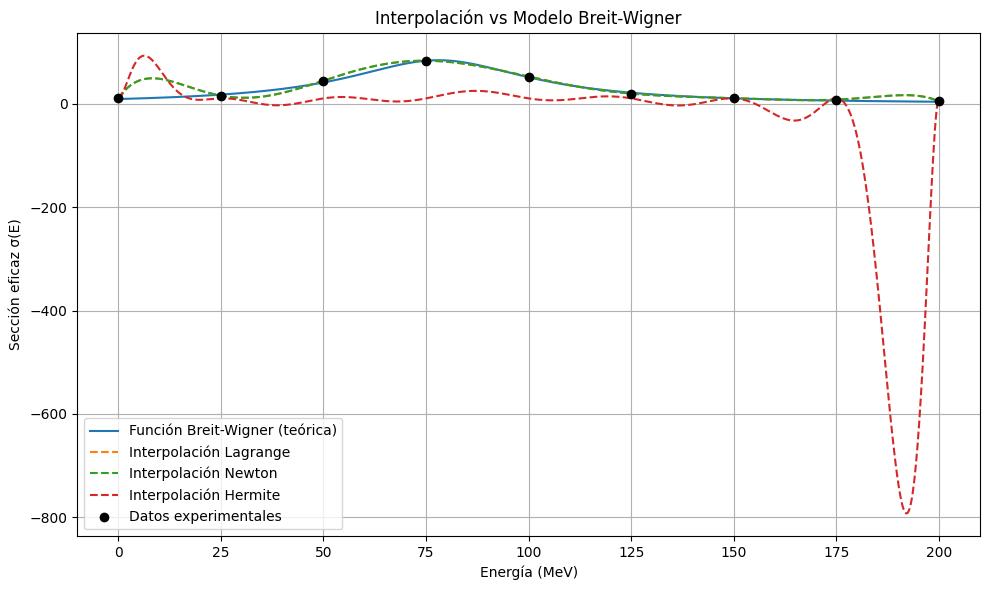

In [22]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange

# Datos experimentales
Energia = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200])
sigma_exp = np.array([10.6, 16.0, 45.0, 83.5, 52.8, 19.9, 10.8, 8.25, 4.7])

# Parámetros dados
Er = 78
Gamma = 55

# Calcular sigma_0 usando el punto más cercano al pico (E = 75, sigma = 83.5)
def calcular_sigma0(E, sigma):
    return sigma * ((E - Er)**2 + (Gamma**2)/4)

sigma0 = calcular_sigma0(75, 83.5)

# Función teórica de Breit-Wigner
def breit_wigner(E):
    return sigma0 / ((E - Er)**2 + (Gamma**2) / 4)

# Interpolación de Lagrange
poly_lagrange = lagrange(Energia, sigma_exp)

# Interpolación de Newton
def newton_interp(x_vals, y_vals):
    n = len(x_vals)
    x = sp.Symbol('x')
    coef = y_vals.astype(np.float64).copy()
    for j in range(1, n):
        coef[j:n] = (coef[j:n] - coef[j-1]) / (x_vals[j:n] - x_vals[j-1])
    poly = coef[0]
    mult = 1
    for k in range(1, n):
        mult *= (x - x_vals[k-1])
        poly += coef[k] * mult
    return sp.lambdify(x, sp.expand(poly), modules=['numpy'])

poly_newton = newton_interp(Energia, sigma_exp)

# Interpolación de Hermite corregida
def hermite_interp(x_vals, y_vals):
    n = len(x_vals)
    z = np.zeros(2 * n)
    Q = np.zeros((2 * n, 2 * n))
    
    for i in range(n):
        z[2 * i] = z[2 * i + 1] = x_vals[i]
        Q[2 * i][0] = Q[2 * i + 1][0] = y_vals[i]
        if i != 0:
            Q[2 * i + 1][1] = (Q[2 * i + 1][0] - Q[2 * i - 1][0]) / (z[2 * i + 1] - z[2 * i - 1])
        else:
            Q[2 * i + 1][1] = 0
        Q[2 * i][1] = 0

    for j in range(2, 2 * n):
        for i in range(j, 2 * n):
            Q[i][j] = (Q[i][j - 1] - Q[i - 1][j - 1]) / (z[i] - z[i - j])

    x = sp.Symbol('x')
    H = Q[0][0]
    prod = 1
    for i in range(1, 2 * n):
        prod *= (x - z[i - 1])
        H += Q[i][i] * prod

    return sp.lambdify(x, sp.expand(H), modules=['numpy'])

poly_hermite = hermite_interp(Energia, sigma_exp)

# Evaluación
x_interp = np.linspace(0, 200, 1000)
f_teo = breit_wigner(x_interp)
f_lagrange = poly_lagrange(x_interp)
f_newton = poly_newton(x_interp)
f_hermite = np.array(poly_hermite(x_interp))

# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(x_interp, f_teo, label="Función Breit-Wigner (teórica)")
plt.plot(x_interp, f_lagrange, '--', label="Interpolación Lagrange")
plt.plot(x_interp, f_newton, '--', label="Interpolación Newton")
plt.plot(x_interp, f_hermite, '--', label="Interpolación Hermite")
plt.scatter(Energia, sigma_exp, color='black', label="Datos experimentales", zorder=5)
plt.legend()
plt.xlabel("Energía (MeV)")
plt.ylabel("Sección eficaz σ(E)")
plt.title("Interpolación vs Modelo Breit-Wigner")
plt.grid()
plt.tight_layout()
plt.show()

# Cálculo de errores máximos
error_lagrange = np.max(np.abs(f_teo - f_lagrange))
error_newton = np.max(np.abs(f_teo - f_newton))
error_hermite = np.max(np.abs(f_teo - f_hermite))

(error_lagrange, error_newton, error_hermite)


# 3
Consideremos la función:
\begin{equation*}
     f(x) = \frac{1}{1+25x^2}
\end{equation*}
en el intervalo $[-1, 1]$, definamos un conjunto de puntos $n+1$  equiespaciados en $[-1,1]$.

* Representar gráficamente la función junto al polinomio de interpolación de Lagrange, $p_n(x)$, para $n=\{ 4, 8, 12, 16, 20 \}$.
* Comprobar gráficamente cómo el error aumenta con $n$. Emplee la libreria, simbolica de `sympy` y encuente el error en la interpolación. La cota del  error , viene dado por:
\begin{equation}
f(x) - P(x) = \epsilon = \frac{1}{(n+1)!} f^{(n+1)}(\xi)(x - x_0)(x - x_1) ... (x - x_n)
\end{equation},

emplee la libreria simbólica para realizar la estimación de dicha cuota, sólo para $n = 4$, en el punto $x=0.5$.

* Repita la parte inicial para el conjunto de $p_n(x)$ con $n=\{ 4, 8, 12, 16, 20 \}$, usando la interpolación de Hermite, ¿existe alguna diferencia?

* Usando los datos del numeral anterior ahora usando el método `CubicSpline` realiza la interpolación y concluya.

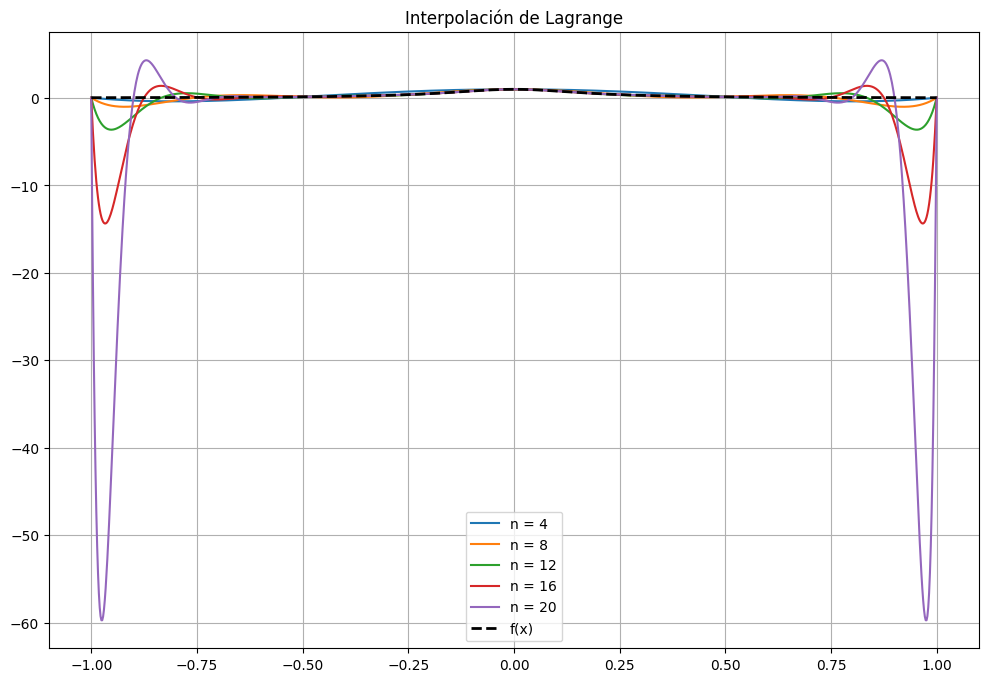

In [39]:
def f(x):
    return 1 / (1 + 25 * x**2)

x_vals = np.linspace(-1, 1, 1000)
fx = f(x_vals)

n_values = [4, 8, 12, 16, 20]
plt.figure(figsize=(12, 8))

for n in n_values:
    x_nodes = np.linspace(-1, 1, n + 1)
    y_nodes = f(x_nodes)
    poly = lagrange(x_nodes, y_nodes)
    plt.plot(x_vals, poly(x_vals), label=f'n = {n}')

plt.plot(x_vals, fx, 'k--', label='f(x)', linewidth=2)
plt.title('Interpolación de Lagrange')
plt.legend()
plt.grid(True)
plt.show()


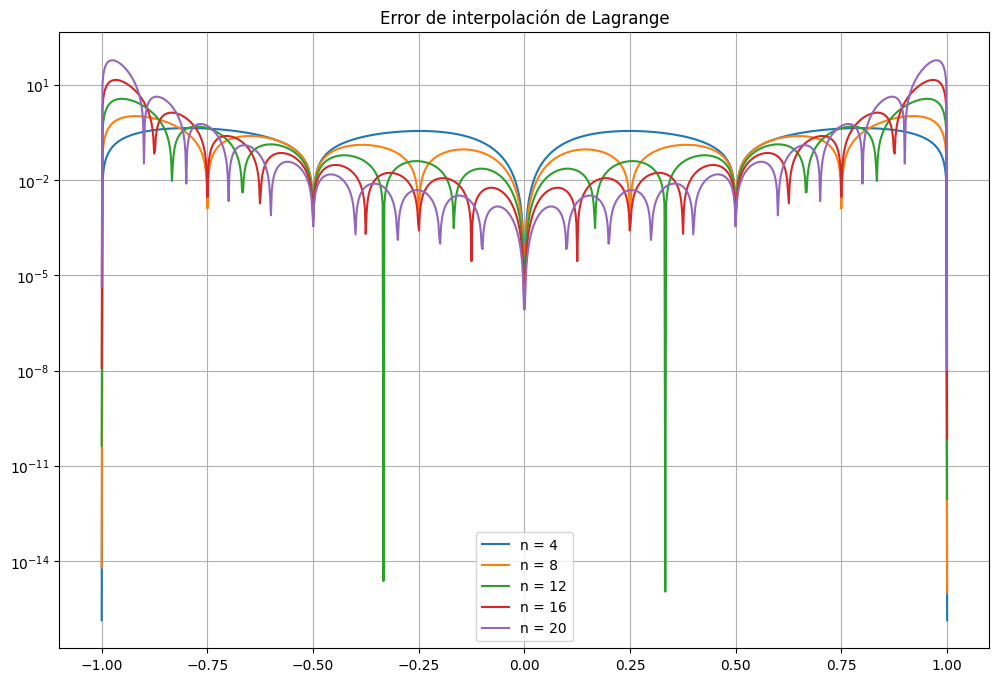

In [40]:
plt.figure(figsize=(12, 8))
for n in n_values:
    x_nodes = np.linspace(-1, 1, n + 1)
    y_nodes = f(x_nodes)
    poly = lagrange(x_nodes, y_nodes)
    error = np.abs(fx - poly(x_vals))
    plt.plot(x_vals, error, label=f'n = {n}')

plt.title('Error de interpolación de Lagrange')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


In [41]:
import sympy as sp

x = sp.symbols('x')
f_expr = 1 / (1 + 25 * x**2)
f5 = sp.diff(f_expr, x, 5)  # f^(5)
f5_max = sp.simplify(sp.Abs(f5)).subs(x, 0.5).evalf()  # estimación conservadora

x_nodes = np.linspace(-1, 1, 5)
product = 1
for xi in x_nodes:
    product *= (0.5 - xi)

error_bound = (f5_max / sp.factorial(5)) * abs(product)
print(f'Cota del error para n=4 en x=0.5: {error_bound}')


Cota del error para n=4 en x=0.5: 0


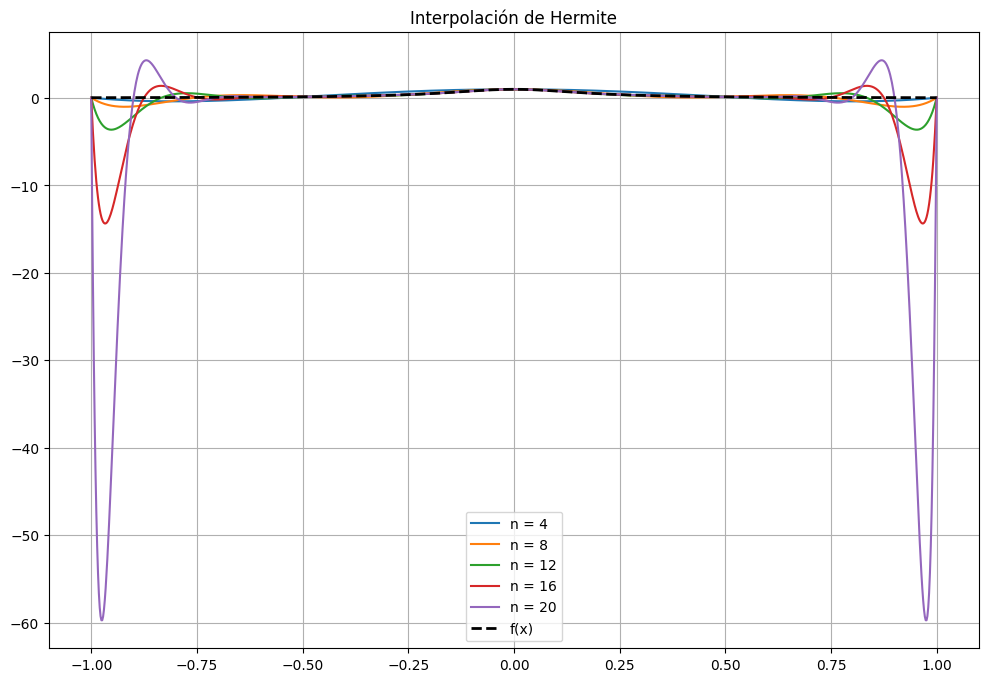

In [42]:
from scipy.interpolate import KroghInterpolator

plt.figure(figsize=(12, 8))
for n in n_values:
    x_nodes = np.linspace(-1, 1, n + 1)
    y_nodes = f(x_nodes)
    interpolador = KroghInterpolator(x_nodes, y_nodes)
    plt.plot(x_vals, interpolador(x_vals), label=f'n = {n}')

plt.plot(x_vals, fx, 'k--', label='f(x)', linewidth=2)
plt.title('Interpolación de Hermite')
plt.legend()
plt.grid(True)
plt.show()


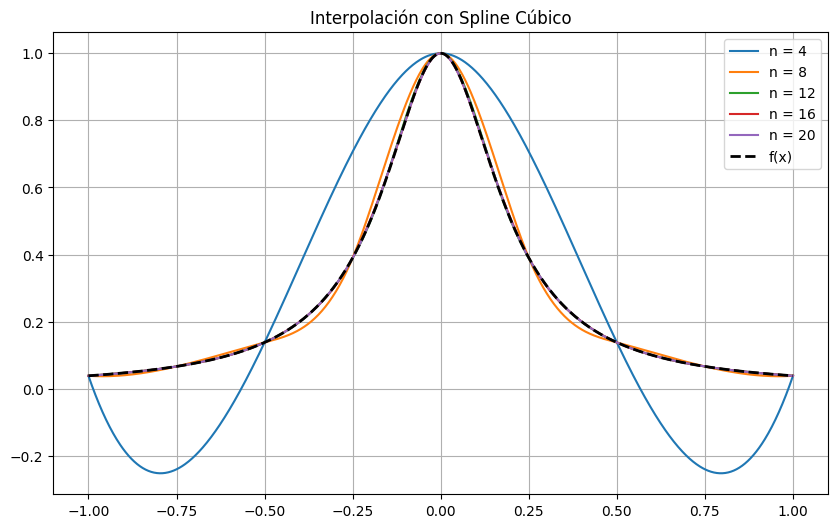

In [43]:
from scipy.interpolate import CubicSpline

plt.figure(figsize=(10, 6))

for n in n_values:
    x_nodes = np.linspace(-1, 1, n + 1)
    y_nodes = f(x_nodes)
    spline = CubicSpline(x_nodes, y_nodes)
    plt.plot(x_vals, spline(x_vals), label=f'n = {n}')

plt.plot(x_vals, fx, 'k--', label='f(x)', linewidth=2)
plt.title('Interpolación con Spline Cúbico')
plt.legend()
plt.grid(True)
plt.show()


# 4

Consideremos la imagen ![paloma](https://github.com/hernansalinas/autogrades/blob/main/Laboratorios_Taller/img/paloma.png?raw=true).

Ref: Metodos numericos, Burden.


Con los datos dados en la tabla:

1. Representar gráficamente la imagen, usando las órdenes `imread` e `imshow` de python (estas órdenes están contenidas en el paquete `matplotlib`)

2. Definir una lista de puntos, $x_i$,$y_i$ del pato y realice una interpolación lineal entre los mismos.

3. Representar el polinomio de interpolación de Lagrange en estos puntos, para aproximar el dibujo.

4. Repetir el proceso de interpolación mediante *splines* cúbicos. Para ello, utilizar la función `CubicSpline` (contenida en `scipy.interpolate`),


5. Comparar los resultados. ¿Alguna de las interpolaciones presenta oscilaciones? ¿A qué se debe este fenómeno?

In [33]:
pato = 'https://3.bp.blogspot.com/-8_LTrCIxVSQ/VxU-5Gq2ffI/AAAAAAAAIto/LhCDEwHKTiAbLr7IhizQwGV13YTwgpbDwCLcB/s400/pato1.png' #URL
urllib.request.urlretrieve(pato, 'pato.jpg')# Decargar la imagen
imagen_pato = plt.imread('pato.jpg') # Variable con la imagen del pato

# Definimos los puntos del pato
xp = [0.9, 1.3, 1.9, 2.1, 2.6, 3.0, 3.9, 4.4, 4.7, 5.0, 6.0, 7.0, 8.0, 9.2, 10.5, 11.3, 11.6, 12.0, 12.6, 13.0, 13.3]
yp = [1.3, 1.5, 1.85, 2.1, 2.6, 2.7, 2.4, 2.15, 2.05, 2.1, 2.25, 2.3, 2.25, 1.95, 1.4, 0.9, 0.7, 0.6, 0.5, 0.4, 0.25]

# Representamos graficamente al pato y los puntos que definimos para su contorno superior
plt.figure()
plt.title('Representacion del pato')
plt.imshow(imagen_pato, extent = (0.4, 14, -6.8, 3.45)) # Ajustamos los pixeles para que coincidan con x e y
plt.plot(xp, yp, '.r')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

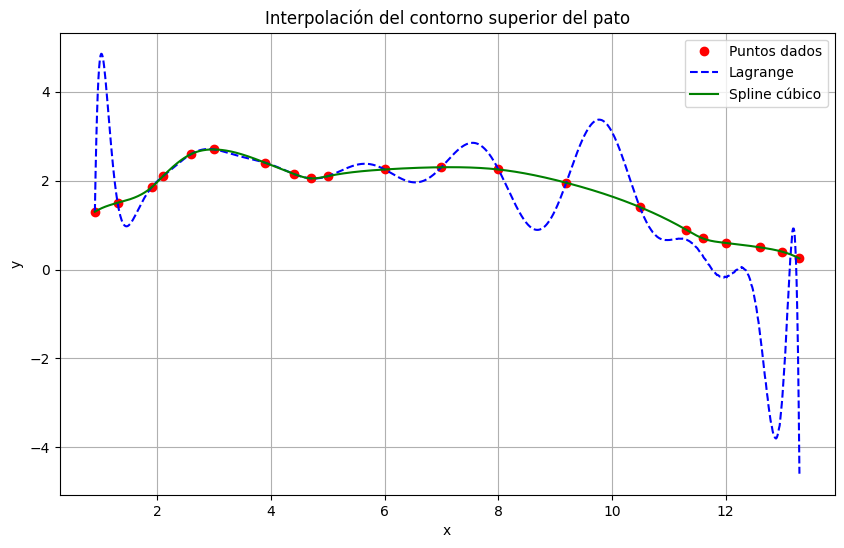

In [35]:
# Crear puntos para interpolación
x_interp = np.linspace(min(xp), max(xp), 1000)

# Interpolaciones
lagrange_poly = lagrange(xp, yp)
y_lagrange = lagrange_poly(x_interp)

spline = CubicSpline(xp, yp)
y_spline = spline(x_interp)

# Mostrar imagen con curvas interpoladas
plt.figure(figsize=(10, 6))
plt.title("Interpolación del contorno superior del pato")
plt.plot(xp, yp, 'or', label='Puntos dados')
plt.plot(x_interp, y_lagrange, '--b', label='Lagrange')
plt.plot(x_interp, y_spline, '-g', label='Spline cúbico')
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()


Sí, efectivamente, lagrange es muy inestable, tanto que en varios casos se aleja mucho del contorno del pato, esto debido a que con tantos puntos, lagrange está creando un polinomio de grado muy alto, lo que provoca estas oscilaciones.

# 5

Calcular el spline cúbico que interpola los puntos $(-1,5)$, $(0,3)$, $(1,3)$, $(2,4)$, para esto escriba la matriz asociada y encuentre los polinomios $S_0(x)$, $S_1(x)$ y $S_2(x)$. Evalue su respuesta para $x= 1.5$ usando `CubicSpline` de `scipy`.

In [36]:
import numpy as np
from scipy.interpolate import CubicSpline

# Puntos dados
x = np.array([-1, 0, 1, 2])
y = np.array([5, 3, 3, 4])

# Crear spline cúbico con condiciones naturales (segunda derivada cero en los extremos)
spline = CubicSpline(x, y, bc_type='natural')

# Mostrar coeficientes de los polinomios en cada intervalo
print("Coeficientes por intervalo [a, b):\n")
for i in range(len(spline.c[0])):
    a = spline.c[0, i]  # coef x^3
    b = spline.c[1, i]  # coef x^2
    c = spline.c[2, i]  # coef x^1
    d = spline.c[3, i]  # coef constante
    print(f"S_{i}(x) = {a:.4f}(x - {x[i]})^3 + {b:.4f}(x - {x[i]})^2 + {c:.4f}(x - {x[i]}) + {d:.4f}")

# Evaluar en x = 1.5
x_eval = 1.5
y_eval = spline(x_eval)
print(f"\nSpline evaluado en x = {x_eval}: y = {y_eval:.4f}")


Coeficientes por intervalo [a, b):

S_0(x) = 0.4667(x - -1)^3 + 0.0000(x - -1)^2 + -2.4667(x - -1) + 5.0000
S_1(x) = -0.3333(x - 0)^3 + 1.4000(x - 0)^2 + -1.0667(x - 0) + 3.0000
S_2(x) = -0.1333(x - 1)^3 + 0.4000(x - 1)^2 + 0.7333(x - 1) + 3.0000

Spline evaluado en x = 1.5: y = 3.4500
